# Execution Time Measurement

In [1]:
import timeit
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
timer = timeit.Timer(setup='import numpy as np',
                    stmt='np.zeros(shape=(4,4))')
timer.timeit(10)

2.2763386368751526e-05

In [15]:
def bench_workload(workload):
    """ Benchmark a workload
        workload: a method that accept a num_repeat argument
        and return its total execution time
    """
    workload(1) #warmup
    time = workload(2)
    if time > 1 :
        return time
    num_repeats = max(int(1.0 / time), 100)
    return workload(num_repeats) / num_repeats

In [16]:
print('time for np.zeros(shape=(4,4)): ', bench_workload(timer.timeit))

time for np.zeros(shape=(4,4)):  3.657626507069832e-07


# The Non-Negligible Overhead

In [17]:
def np_setup(n):
    return 'import numpy as np\n' \
            'x = np.random.normal(size=%d).astype("float32")\n' \
            'y = np.empty_like(x)\n'% n

def np_copy(n):
    return timeit.Timer(setup=np_setup(n),
                       stmt='np.copyto(y, x)')

In [18]:
sizes = 2 ** np.arange(5, 20, 2).astype('int')
exe_times = [bench_workload(np_copy(n).timeit) for n in sizes]

/tmp/ipykernel_13836/21911991.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


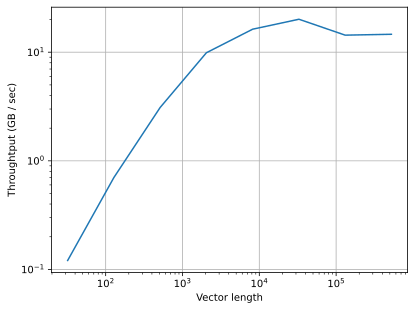

In [19]:
display.set_matplotlib_formats('svg')
plt.loglog(sizes, sizes * 4 / exe_times / 1e9)
plt.xlabel('Vector length')
plt.ylabel('Throughtput (GB / sec)')
plt.grid()

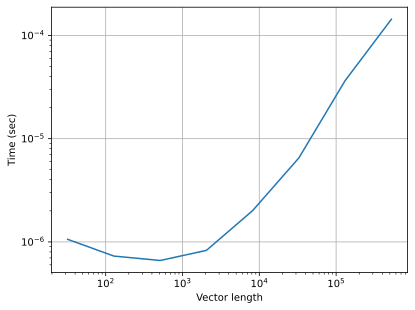

In [20]:
plt.loglog(sizes, exe_times)
plt.xlabel('Vector length')
plt.ylabel('Time (sec)')
plt.grid()

# Overhead of Numpy, TVM, Torch

In [26]:
sizes = 2 ** np.arange(1, 8).astype('int32')
exe_times = np.array([bench_workload(np_copy(n).timeit) for n in sizes])

print('Numpy call overhead: %.1f microsecond' % (exe_times.mean() * 1e6))

Numpy call overhead: 0.9 microsecond


In [27]:
def tvm_copy(n):
    return timeit.Timer(setup=np_setup(n) + 'import tvm\n'
                       'x, y = tvm.nd.array(x), tvm.nd.array(y)',
                       stmt='x.copyto(y)')

tvm_times = np.array([bench_workload(tvm_copy(n).timeit) for n in sizes])
print('TVM call overhead: %.1f microsecond' % (tvm_times.mean() * 1e6))

TVM call overhead: 0.8 microsecond


In [33]:
import torch
def torch_copy(n):
    return timeit.Timer(setup=np_setup(n) + 'import torch\n'
                       'x, y = torch.Tensor(x), torch.Tensor(y)' % n,
                       stmt='y.copy_(x)')
torch_times = np.array([bench_workload(torch_copy(n).timeit) for n in sizes])
print('Torch call overhead: %.1f microsecond' % (torch_times.mean() * 1e6))

Torch call overhead: 1.0 microsecond


# Summary
1.Warming up a method by running it a few times beforehand is a good practice to measure its execution time. \
2.The function call overhead might takes several microsecond. Benchmarking too small functions in Python is meaningless.